# Test Time Reinforcement Learning

This notebook implements the core training loop of the CBOW Word2Vec model using only NumPy.

### Task Description (Provided by JetBrains)
Implement the core training loop of word2vec in pure NumPy (no PyTorch / TensorFlow or other ML frameworks). The applicant is free to choose any suitable text dataset. The task is to implement the optimization procedure (forward pass, loss, gradients, and parameter updates) for a standard word2vec variant (e.g. skip-gram with negative sampling or CBOW).

The submitted solution should be fully understood by the applicant: during follow-up we will ask questions about the ideas behind word2vec, the code, gradient derivations, and possible alternative implementations or optimizations.

In [1]:
# Load the required libraries
import numpy as np
import pandas as pd
import os
import string
import nltk
from collections import Counter
from loguru import logger


# Visualisation libraries
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE

Main Word2Vec class

In [2]:
class Word2Vec:
    """
    CBOW Word2Vec (pure NumPy).
    """

    def __init__(
        self,
        embedding_dim,
        learning_rate,
        epochs,
        window_size,
        K,
        min_count=1,
        seed=42,
        shuffle=True
    ):
        self.embedding_dim = embedding_dim
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.window_size = window_size
        self.K = K
        self.min_count = min_count
        self.shuffle = shuffle

        self.prng = np.random.RandomState(seed)

        # Will be initialized in fit()
        self.vocab = None
        self.word_to_index = None
        self.index_to_word = None
        self.v_w = None
        self.v_c = None
        self.training_data = None
        self.performance = None

    def fit(self, text):
        """
        Train Word2Vec on raw text.
        """
        # Preprocess text
        tokens = self._preprocess(text)

        self._build_vocab(tokens)

        # Initialize embeddings
        self._initialize_weights()

        # Create training data
        self.training_data = self._create_training_data(tokens)

        # Train
        self._train()

    def predict(self, word):
        """Return embedding of a word."""
        if word not in self.word_to_index:
            raise ValueError("Word not in vocabulary.")
        return self.v_w[self.word_to_index[word]]
    
    def _preprocess(self, text):
        # Basic preprocessing: lowercase and split
        tokens = text.lower().split()
        return tokens

    def _build_vocab(self, tokens):
        # Count word frequencies
        counter = Counter(tokens)

        # Remove rare words
        self.vocab = sorted(
            [w for w, c in counter.items() if c >= self.min_count]
        )
        # Create word-index mappings
        self.word_to_index = {w: i for i, w in enumerate(self.vocab)}
        self.index_to_word = {i: w for w, i in self.word_to_index.items()}

    def _initialize_weights(self):
        # Initialize target and context embeddings with small random values
        vocab_size = len(self.vocab)

        # Using uniform distribution to create initial embeddings for both target and context
        self.v_w = self.prng.uniform(
            -0.5, 0.5, (vocab_size, self.embedding_dim)
        )
        self.v_c = self.prng.uniform(
            -0.5, 0.5, (vocab_size, self.embedding_dim)
        )


    def _create_training_data(self, tokens):
        # Create training data as (target, context, negative_samples) tuples
        training_data = []

        # Convert tokens to indices, filtering out words not in the vocab
        token_ids = [
            self.word_to_index[t]
            for t in tokens
            if t in self.word_to_index
        ]

        vocab_size = len(self.vocab)

        # For each target word, collect context words and sample negative examples
        for i, target_id in enumerate(token_ids):
            # Define the context window
            start = max(0, i - self.window_size)
            end = min(len(token_ids), i + self.window_size + 1)
            # Collect context word indices, excluding the target word itself
            context_ids = [
                token_ids[j]
                for j in range(start, end)
                if j != i
            ]
            # Skip if no context words (e.g., at the beginning or end of the text)
            if not context_ids:
                continue
            # Sample negative examples (ensure they are not the target word)
            neg_ids = []
            while len(neg_ids) < self.K:
                neg_id = self.prng.randint(0, vocab_size)
                if neg_id != target_id:
                    neg_ids.append(neg_id)
            # Append the training example as a tuple of (context_ids, target_id, neg_ids)
            training_data.append(
                (context_ids, target_id, neg_ids)
            )

        return training_data

    def _train(self):
        self.performance = {
            "loss_train": np.zeros(self.epochs)
        }
        # Training loop
        for epoch in range(self.epochs):
            if self.shuffle:
                self.prng.shuffle(self.training_data)

            epoch_loss = 0.0
            # Iterate over each training example
            for context_ids, target_id, neg_ids in self.training_data:

                # Forward pass, compute scores and loss
                pos_score, neg_scores, v_hat, v_context, v_target, v_neg = \
                    self._forward(context_ids, target_id, neg_ids)
                
                # Compute loss for this example
                loss = self._neg_sampling_loss(pos_score, neg_scores)
                epoch_loss += loss

                # Backward pass, update embeddings based on gradients
                self._backward(
                    context_ids,
                    target_id,
                    neg_ids,
                    pos_score,
                    neg_scores,
                    v_hat,
                    v_target,
                    v_neg
                )
            # Average loss for the epoch
            self.performance["loss_train"][epoch] = \
                epoch_loss / len(self.training_data)
            
            # Log epoch performance
            logger.info(
                f"Epoch {epoch+1}/{self.epochs} - "
                f"Loss: {self.performance['loss_train'][epoch]:.4f}"
            )


    def _forward(self, context_ids, target_id, neg_ids):
        # Get embeddings for target, positive context, and negative contexts
        # Context embeddings
        v_context = self.v_w[context_ids]     # (C, D)

        # Average context
        v_hat = np.mean(v_context, axis=0)    # (D,)

        # Target embedding
        v_target = self.v_c[target_id]

        # Negative embeddings
        v_neg = self.v_c[neg_ids]

        pos_score = np.dot(v_target, v_hat)
        neg_scores = np.dot(v_neg, v_hat)

        return pos_score, neg_scores, v_hat, v_context, v_target, v_neg

    def _backward(
        self,
        context_ids,
        target_id,
        neg_ids,
        pos_score,
        neg_scores,
        v_hat,
        v_target,
        v_neg ):
        # Compute sigmoid scores for positive and negative samples
        pos_sig = self._sigmoid(pos_score)
        neg_sig = self._sigmoid(neg_scores)

        # gradient wrt averaged context vector
        grad_v_hat = (
            (pos_sig - 1) * v_target +
            np.sum(neg_sig[:, None] * v_neg, axis=0)
        )

        # Udate context word embeddings
        for context_id in context_ids:
            self.v_w[context_id] -= (
                self.learning_rate *
                grad_v_hat / len(context_ids)
            )

        # Update positive target embedding
        self.v_c[target_id] -= (
            self.learning_rate *
            (pos_sig - 1) * v_hat
        )

        # Update negative embeddings
        for i, neg_id in enumerate(neg_ids):
            self.v_c[neg_id] -= (
                self.learning_rate *
                neg_sig[i] * v_hat
            )

    def _neg_sampling_loss(self, pos_score, neg_scores):
        # Compute negative sampling loss
        loss = (
            -np.log(self._sigmoid(pos_score))
            - np.sum(np.log(self._sigmoid(-neg_scores)))
        )

        return loss

    def _sigmoid(self, x):
        # To prevent overflow, the input is clipped to a reasonable range
        x = np.clip(x, -10, 10)
        # Sigmoid function
        return 1 / (1 + np.exp(-x))


In [3]:
# Download the Brown corpus for evaluation (if not already downloaded)
nltk.download('brown')

# Initialize and train Word2Vec
word2vec = Word2Vec(
    embedding_dim=50,
    learning_rate=0.025,
    epochs=5,
    K=5,
    window_size=10
)
# Use the first 200,000 words from the Brown corpus for training
text = " ".join(nltk.corpus.brown.words()[:200_000])

# fit the model
word2vec.fit(text)


print("Training loss over epochs:", word2vec.performance["loss_train"])

[nltk_data] Downloading package brown to
[nltk_data]     C:\Users\pavel\AppData\Roaming\nltk_data...
[nltk_data]   Package brown is already up-to-date!
2026-02-19 13:27:25.400 | INFO     | __main__:_train:167 - Epoch 1/5 - Loss: 2.5571
2026-02-19 13:28:14.426 | INFO     | __main__:_train:167 - Epoch 2/5 - Loss: 1.5211
2026-02-19 13:29:03.459 | INFO     | __main__:_train:167 - Epoch 3/5 - Loss: 1.4740
2026-02-19 13:29:52.332 | INFO     | __main__:_train:167 - Epoch 4/5 - Loss: 1.4470
2026-02-19 13:30:41.542 | INFO     | __main__:_train:167 - Epoch 5/5 - Loss: 1.4269


Training loss over epochs: [2.55707056 1.52107294 1.47397869 1.44697435 1.426943  ]


Embedding for 'news': [ 0.33000208  0.05184637 -0.274864    0.06488619  0.14485741 -0.25396845
  0.06915455  0.43927133  0.26901401 -0.14683988  0.32789521 -0.0459658
 -0.45644579 -0.33543412 -0.54324348  0.25928706  0.21933972 -0.2335845
 -0.18703823 -0.09643606 -0.34795502 -0.50205766 -0.17551279  0.16118881
  0.45078073  0.54794847  0.26202984 -0.20622818 -0.3447104  -0.15763831
  0.24047723  0.35820851  0.22707784  0.18448011 -0.3380534  -0.40355076
  0.3187191   0.17856758  0.16278342  0.38415171  0.4295512   0.34485447
  0.11391353 -0.29849599 -0.02865519 -0.34395013  0.14741356  0.32986737
 -0.30199788 -0.52528819]


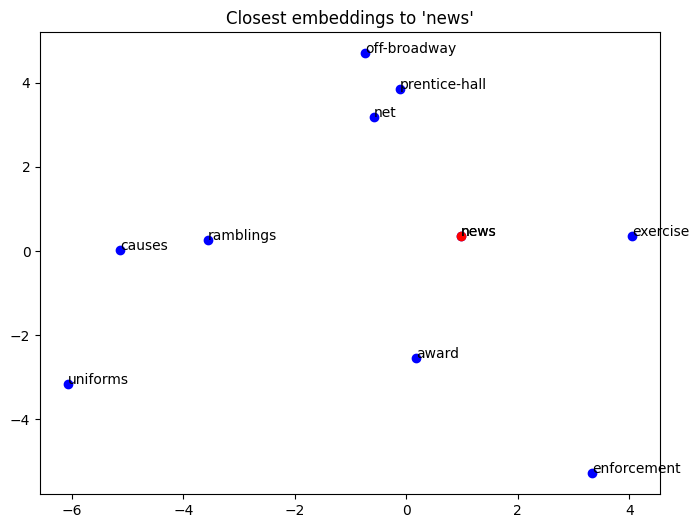

In [4]:
# Get embedding for a word
word2vec.predict("news")

print("Embedding for 'news':", word2vec.predict("news"))

# Visualize closest embeddings to the given word using TSNE
def plot_closest_embeddings(word, model, top_n=15):
    word_embedding = model.predict(word)
    distances = []
    all_embeddings = model.v_w
    word_embedding = model.predict(word)

    # Using L2 distance to find closest embeddings
    dist = np.linalg.norm(all_embeddings - word_embedding, axis=1)

    # for each word in the vocab, pair it with its distance to the target word
    distances = [(other_word, d) for other_word, d in zip(model.word_to_index.keys(), dist)]
    distances.sort(key=lambda x: x[1])
    closest_words = [w for w, d in distances[:top_n]]

    # Get embeddings for closest words and the target word
    embeddings = np.array([model.predict(w) for w in closest_words + [word]])
    tsne = TSNE(init = 'pca', method = 'exact', n_components=10, random_state=42, perplexity=5, max_iter=1000)
    reduced_embeddings = tsne.fit_transform(embeddings)

    # Plotting
    plt.figure(figsize=(8, 6))
    plt.scatter(reduced_embeddings[:-1, 0], reduced_embeddings[:-1, 1], color='blue')
    plt.scatter(reduced_embeddings[-1, 0], reduced_embeddings[-1, 1], color='red')
    for i, w in enumerate(closest_words + [word]):
        plt.annotate(w, (reduced_embeddings[i, 0], reduced_embeddings[i, 1]))
    plt.title(f"Closest embeddings to '{word}'")
    plt.show()
# Visualize closest embeddings to "news" using TSNE (only 9 closest words for better visualization)
plot_closest_embeddings("news", word2vec, top_n=10)